### Zadanie 1



K (macierz kamery):
 [[335.41359465   0.         345.29127331]
 [  0.         335.24805769 232.90622819]
 [  0.           0.           1.        ]]

D (dystorsja):
 [[-0.02456449]
 [-0.01755001]
 [ 0.02354855]
 [-0.01392081]]

Błąd kalibracji (średni): 0.114036


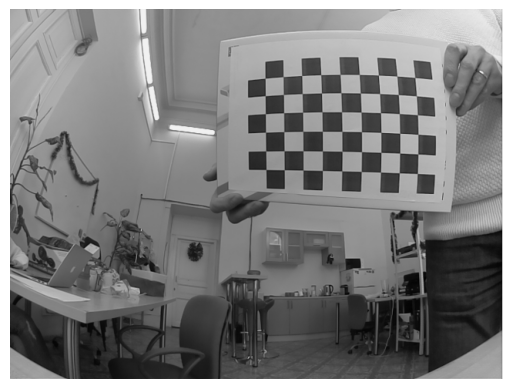

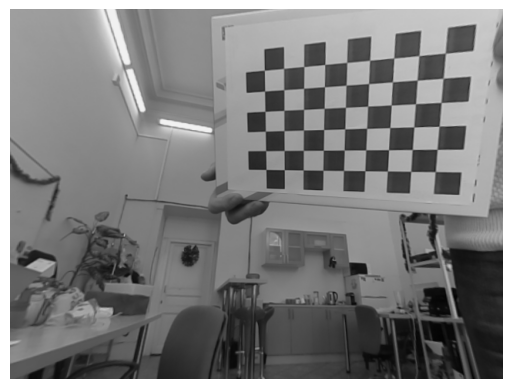

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Ustalenie kryteriów na max 30 epok lub gdy błąd dopasowania bedzie na poziomie 0.001
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# Flagi używane do kalibracji. 
# RECOMPUTE_EXTRINSIC - wymusza ponowne obliczenie macierzy zewnetrznej rotaci
# FIX_SKEW - zakłąda brak przkoszeń (brak ukośnego zniekszatałcenia)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW

# Szachownica posiada 9 na 6 wewntrzych narozników czyli składa sie z 10 na 7 kwadracików
width = 9
height = 6
square_size = 0.025  # Size of square in meters

# Prepare object points
objp = np.zeros((height * width, 1, 3), np.float64)           # Tworzy obraz 54, 1, 3 wypelniony zerami
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2) # Tworzxy baze wsplrzednych dla osi x i y
objp *= square_size                                           # Skaluje do prawdziwego rozmiaru

# Arrays to store object and image points
objpoints = []
imgpoints = []

# Image size and directory
img_width = 640
img_height = 480
image_size = (img_width, img_height)

image_dir = "pairs/"
number_of_images = 50

for i in range(1, number_of_images):
    img_path = os.path.join(image_dir, f"left_{i:02d}.png")
    img = cv2.imread(img_path)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(                                                  # Wbudowana funckja do znajdowania naroży szachownicy
        gray, (width, height),                                                                 # Wymairy aby dodpasowac pattern poszuwikawń 
        cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE  # Adaptacyjne progowanie, Szybkie spawdzenie, Poprawa kontrastu
    )

    if ret:
        Y, X = img.shape[:2]                 
        minRx = corners[:, 0, 0].min()              # Sprawdzenie czy narożniki nie są zbyt blisko brzegu
        maxRx = corners[:, 0, 0].max()
        minRy = corners[:, 0, 1].min()              # Sprawdzenie czy narożniki nie są zbyt blisko brzegu
        maxRy = corners[:, 0, 1].max()

        border_threshold_x = X / 12
        border_threshold_y = Y / 12

       # if minRx < border_threshold_x or minRy < border_threshold_y:
      #      continue

        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), criteria)    # Doprecyzowanie pozycji pikseli 
        imgpoints.append(corners2)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (width, height), corners2, ret)           # Wyświetlenie narożników pikseli
        cv2.imshow("Corners", img)
        cv2.waitKey(100)
    else:
        print(f"Chessboard couldn't be detected. Image pair: {i}")

cv2.destroyAllWindows()


N_OK = len(objpoints)                                                   # Liczba obrazów
K = np.zeros((3, 3))                                                    # Inicializacja macierzy K
D = np.zeros((4, 1))                                                    # Inicializacja macierzy D
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]    # Macierz obrotu dla każdego obrazu
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]    # Macierz tranzlacji (położenia obrazu wzglegdem kamery)
 
ret, K, D, _, _ = cv2.fisheye.calibrate(                                 #####################
    objpoints,                                                           #                   #
    imgpoints,                                                           #                   #
    image_size,                                                          #                   #
    K,                                                                   #                   #
    D,                                                                   #    kalibracjka    #
    rvecs,                                                               #                   #
    tvecs,                                                               #                   #
    calibration_flags,                                                   #                   #
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)       #                   #
)                                                                        #####################

print("\nK (macierz kamery):\n", K)
print("\nD (dystorsja):\n", D)
print(f"\nBłąd kalibracji (średni): {ret:.6f}")

# Wczytaj przykładowy obraz do prostowania
sample_img_path = os.path.join(image_dir, "left_01.png")
img = cv2.imread(sample_img_path)
map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, image_size, cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)

# Wyświetl efekt
plt.imshow(img)
plt.axis('off')
plt.show()
plt.imshow(undistorted_img)
plt.axis('off')
plt.show()

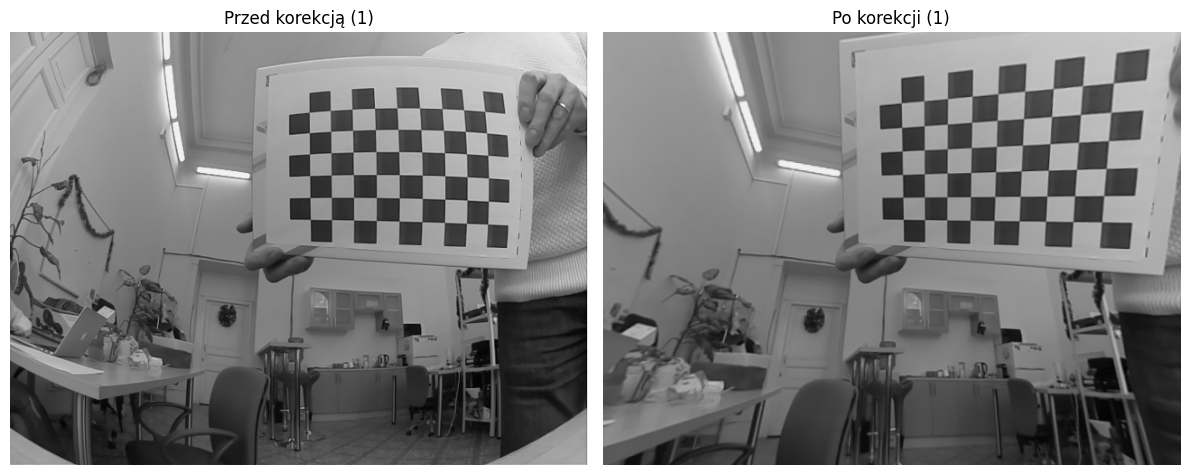

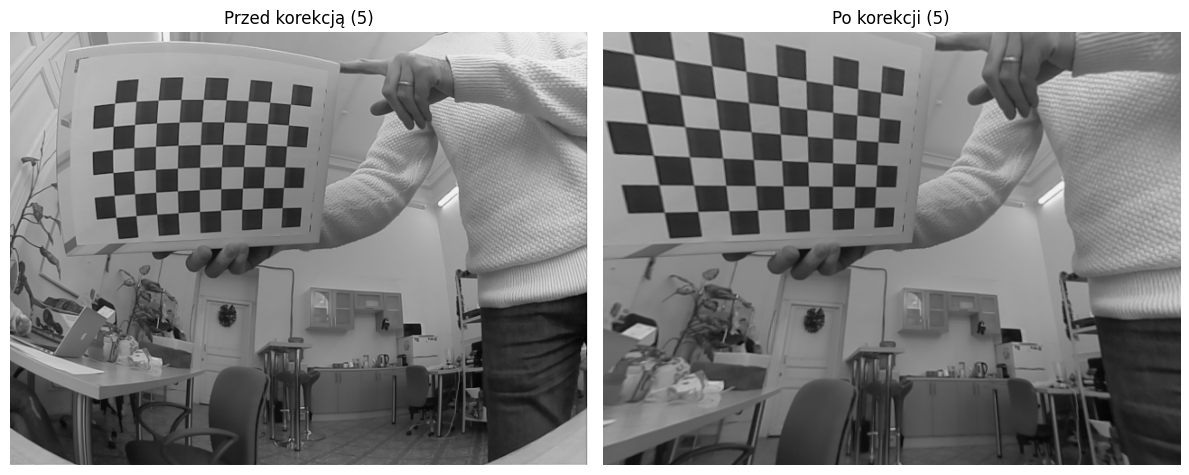

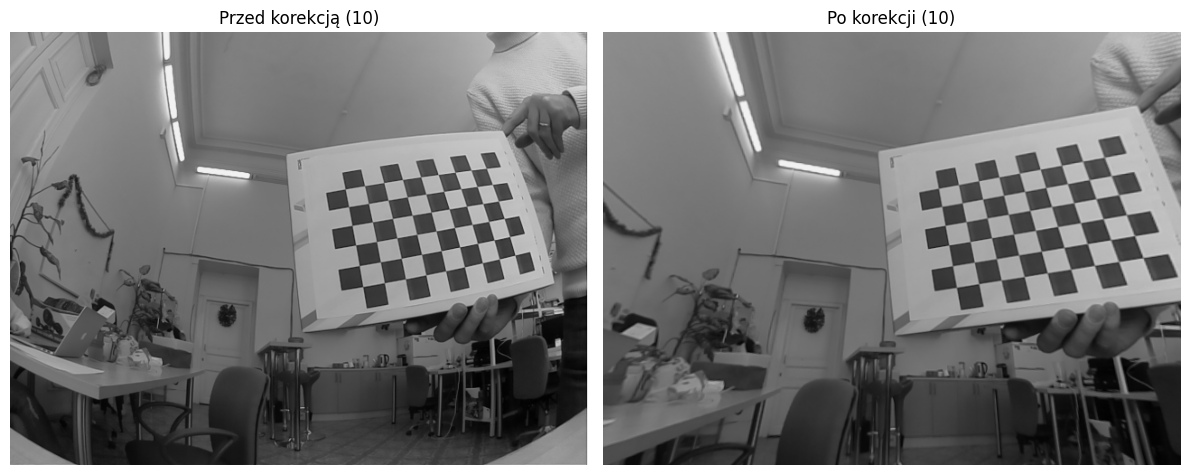

In [10]:
sample_img_path = os.path.join(image_dir, "left_01.png")

sample_img_path = os.path.join(image_dir, "left_10.png")

sample_ids = [1, 5, 10]

for i in sample_ids:
    sample_img_path = os.path.join(image_dir, f"left_{i:02d}.png")
    img = cv2.imread(sample_img_path)

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D,   # Fukcja zwraca mapy dla X i Y jak anlerzy porzsunac piksele aby usnunac zniekształecenia 
                                                     np.eye(3),
                                                     K,
                                                     image_size,
                                                     cv2.CV_16SC2)  
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR)   # przemapowanie obrazu

    # Wyświetlenie przed i po
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Przed korekcją ({i})")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"Po korekcji ({i})")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


### Zadanie 2

In [ ]:
import os

image_path = "/home/plorenc/Desktop/AiR_ISS/AVS/pairs"

right_file = []
left_file = []

for dirpath, dirnames, filenames in os.walk(image_path):
    for file in filenames:
        file_path = os.path.join(dirpath, file)
        if "left" in file:
            left_file.append(file_path)
        elif "right" in file:
            right_file.append(file_path)

len(right_file), len(left_file)

(49, 49)

# Zapytac sie co jest nie tak z tymi pętlami

In [16]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + cv2.fisheye.CALIB_FIX_SKEW
width, height = 9, 6
square_size = 0.025
image_size = (640, 480)
objp = np.zeros((height * width, 1, 3), np.float64)
objp[:, 0, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2) * square_size

objpoints, imgpoints_left, imgpoints_right = [], [], []


"""
for l_path, r_path in zip(right_file, left_file):
    img_l = cv2.imread(l_path)
    img_r = cv2.imread(r_path)
    if img_l is None or img_r is None: continue
    gray_l, gray_r = map(cv2.cvtColor, [img_l, img_r], [cv2.COLOR_BGR2GRAY]*2)
"""

for i in range(1, 50):
    img_l = cv2.imread(f"{image_dir}left_{i:02d}.png")
    img_r = cv2.imread(f"{image_dir}right_{i:02d}.png")
    if img_l is None or img_r is None: continue
    gray_l, gray_r = map(cv2.cvtColor, [img_l, img_r], [cv2.COLOR_BGR2GRAY]*2)

    ret_l, corners_l = cv2.findChessboardCorners(gray_l, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    ret_r, corners_r = cv2.findChessboardCorners(gray_r, (width, height), cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    if ret_l and ret_r:
        objpoints.append(objp)
        corners_l = cv2.cornerSubPix(gray_l, corners_l, (3, 3), (-1, -1), criteria)
        corners_r = cv2.cornerSubPix(gray_r, corners_r, (3, 3), (-1, -1), criteria)
        imgpoints_left.append(corners_l)
        imgpoints_right.append(corners_r)
        cv2.drawChessboardCorners(gray_l, (width, height), corners_l, ret_l)
        cv2.drawChessboardCorners(gray_r, (width, height), corners_r, ret_r)

        compose = cv2.hconcat([gray_l, gray_r])
        cv2.imshow("combine", compose)
        cv2.waitKey(5)

cv2.destroyAllWindows()

(-0.5, 1279.5, 479.5, -0.5)

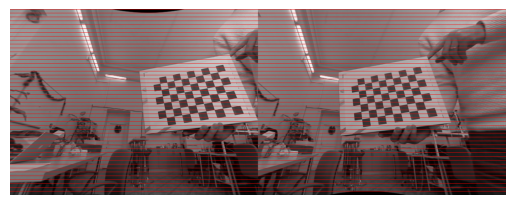

In [17]:
def calibrate_fisheye(objpoints, imgpoints, size):
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3)) for _ in objpoints]
    tvecs = [np.zeros((1, 1, 3)) for _ in objpoints]
    _, K, D, _, _ = cv2.fisheye.calibrate(objpoints, imgpoints, size, K, D, rvecs, tvecs, flags, criteria)
    return K, D

K_l, D_l = calibrate_fisheye(objpoints, imgpoints_left, image_size)
K_r, D_r = calibrate_fisheye(objpoints, imgpoints_right, image_size)

imgpoints_left = np.asarray(imgpoints_left, dtype=np.float64)
imgpoints_right = np.asarray(imgpoints_right, dtype=np.float64)

_, _, _, _, _, R, T = cv2.fisheye.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, K_l, D_l, K_r, D_r, image_size, None, None, cv2.CALIB_FIX_INTRINSIC, criteria)

R2, P1, P2, Q = [np.zeros((3, 3))] * 3 + [np.zeros((4, 4))]
R1, R2, P1, P2, Q = cv2.fisheye.stereoRectify(K_l, D_l, K_r, D_r, image_size, R, T, 0, R2, P1, P2, Q, cv2.CALIB_ZERO_DISPARITY, (0, 0))

map1_l, map2_l = cv2.fisheye.initUndistortRectifyMap(K_l, D_l, R1, P1, image_size, cv2.CV_16SC2)
map1_r, map2_r = cv2.fisheye.initUndistortRectifyMap(K_r, D_r, R2, P2, image_size, cv2.CV_16SC2)

test_idx = 10
img_l = cv2.imread(f"{image_dir}left_{test_idx:02d}.png")
img_r = cv2.imread(f"{image_dir}right_{test_idx:02d}.png")

rect_l = cv2.remap(img_l, map1_l, map2_l, cv2.INTER_LINEAR)
rect_r = cv2.remap(img_r, map1_r, map2_r, cv2.INTER_LINEAR)
vis = np.hstack((rect_l, rect_r))

for y in range(0, vis.shape[0], 10):
    cv2.line(vis, (0, y), (vis.shape[1], y), (255, 0, 0), 1)

plt.imshow(vis)
plt.axis('off')


### Zadanie 3


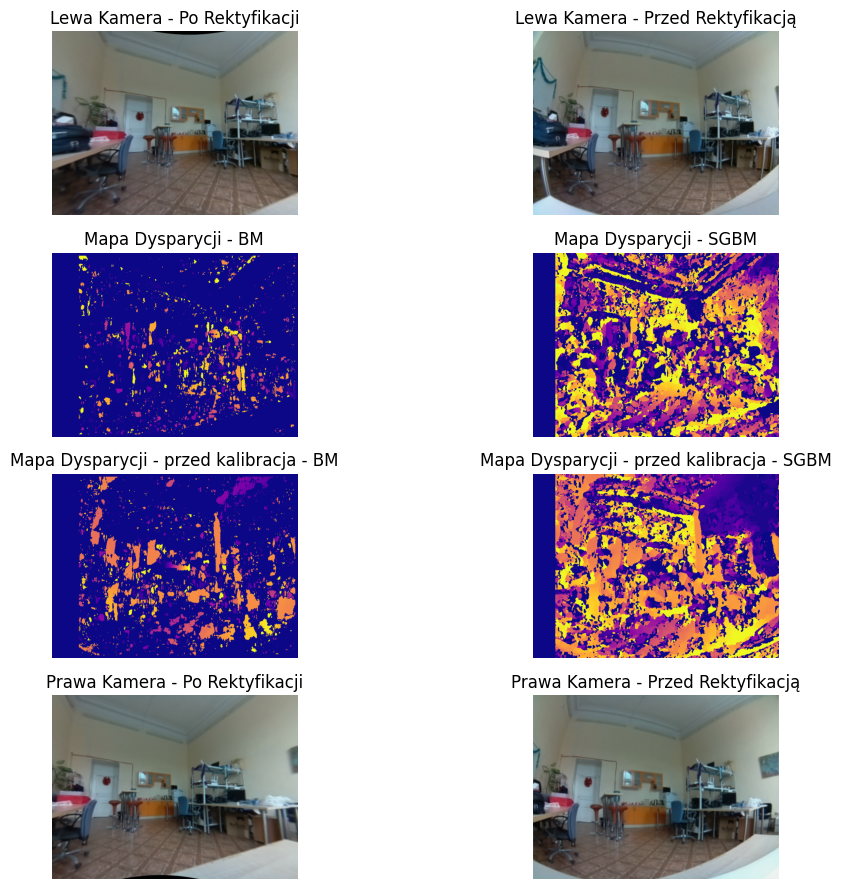

In [18]:
import cv2
import matplotlib.pyplot as plt

def undistort_and_rectify_fisheye(img, K, D, R, P):
    """
    img  — oryginalny obraz z kamery typu fisheye
    K    — macierz kamery
    D    — współczynniki dystorsji
    R    — macierz rektyfikacji
    P    — nowa macierz projekcji
    """
    h, w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, R, P, (w, h), cv2.CV_16SC2)
    rectified_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return rectified_img

img = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/example/example1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konwersja BGR do RGB
img = cv2.resize(img, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_LINEAR)

height, width = img.shape[:2]

img_left_before = img[:, :width // 2]
img_right_before = img[:, width // 2:]

img_left_gray_before = cv2.cvtColor(img_left_before, cv2.COLOR_RGB2GRAY)
img_right_gray_before = cv2.cvtColor(img_right_before, cv2.COLOR_RGB2GRAY)

img_left = undistort_and_rectify_fisheye(img_left_before, K_l, D_l, R1, P1)
img_right = undistort_and_rectify_fisheye(img_right_before, K_r, D_r, R2, P2)

img_left_gray = cv2.cvtColor(img_left, cv2.COLOR_RGB2GRAY)
img_right_gray = cv2.cvtColor(img_right, cv2.COLOR_RGB2GRAY)


stereo_bm = cv2.StereoBM_create(
    numDisparities = 16*4,            # Im wieksza liczby tym wieksza dokladnosc odwzorwania glebi ale wiesza kosz obliczeniowy
    blockSize=15                      # Rozmir okana który uzyw sie do porowanania obrazów 
)

disparity_bm_calib = stereo_bm.compute(img_left_gray, img_right_gray)                   # Wyliczenie dla skalibrownych
disparity_bm_nocalib = stereo_bm.compute(img_left_gray_before, img_right_gray_before)   # Wyliczenie dla skalibrownych

stereo_sgbm = cv2.StereoSGBM_create(
    minDisparity=10,                    # Minimalna dysparycja         
    numDisparities=16*3,               # Liczba dysparycji 
    blockSize=14                       # Rozmiar bloku
)

disparity_sgbm_calib = stereo_sgbm.compute(img_left_gray, img_right_gray) # Wyliczneie dla skaliborwanego
disparity_sgbm_nocalib = stereo_sgbm.compute(img_left_gray_before, img_right_gray_before) # Wyliczneie dla skaliborwanego

fig, axs = plt.subplots(4, 2, figsize=(12, 9))
axs = axs.flatten()

for ax in axs:
    ax.axis('off')

axs[0].imshow(img_left)
axs[0].set_title("Lewa Kamera - Po Rektyfikacji")

axs[1].imshow(img_left_before)
axs[1].set_title("Lewa Kamera - Przed Rektyfikacją")

axs[2].imshow(disparity_bm_calib, cmap='plasma')
axs[2].set_title("Mapa Dysparycji - BM")

axs[3].imshow(disparity_sgbm_calib, cmap='plasma')
axs[3].set_title("Mapa Dysparycji - SGBM")


axs[4].imshow(disparity_bm_nocalib, cmap='plasma')
axs[4].set_title("Mapa Dysparycji - przed kalibracja - BM")

axs[5].imshow(disparity_sgbm_nocalib, cmap='plasma')
axs[5].set_title("Mapa Dysparycji - przed kalibracja - SGBM")

axs[6].imshow(img_right)
axs[6].set_title("Prawa Kamera - Po Rektyfikacji")

axs[7].imshow(img_right_before)
axs[7].set_title("Prawa Kamera - Przed Rektyfikacją")

plt.tight_layout()
plt.show()


### Zadanie 1 Dodatkowe

In [ ]:
import numpy as np
from tqdm.auto import tqdm


class CensusTransform():
    def __init__(self, ksize=5, dmax=32):
        self.ksize = ksize
        self.half_ksize = ksize // 2
        self.dmax = dmax

    def __kernel_thresh(self, img):
        height, width = img.shape[:2]
        census_map = np.zeros((height - self.ksize + 1, width - self.ksize + 1), dtype=np.uint32)

        for y in tqdm(range(self.half_ksize, height - self.half_ksize)):
            for x in range(self.half_ksize, width - self.half_ksize):
                block = img[y - self.half_ksize:y + self.half_ksize + 1, x - self.half_ksize:x + self.half_ksize + 1]

                center_pixel = block[self.half_ksize, self.half_ksize]  # Piksel w środku bloku
                binary_pattern = 0

                # Binarne porównanie z wartością piksela w środku
                for i in range(self.ksize):
                    for j in range(self.ksize):
                        if block[i, j] >= center_pixel:
                            binary_pattern |= (1 << (i * self.ksize + j))  # Przypisanie 1, jeśli piksel większy niż środkowy

                census_map[y - self.half_ksize, x - self.half_ksize] = binary_pattern

        return census_map

    def apply(self, img_left, img_right):
        census_map_left = self.__kernel_thresh(img_left)
        census_map_right = self.__kernel_thresh(img_right)

        # Inicjalizacja mapy dysparycji
        dispersion_map = np.zeros((census_map_left.shape[0], census_map_right.shape[1]), dtype=np.uint64)

        for y in tqdm(range(census_map_left.shape[0])):
            for x in range(census_map_left.shape[1]):
                min_diff = float('inf')
                best_d = 0

                # Przesuwamy wzdłuż osi X (w prawo)
                for d in range(self.dmax):
                    if x + d < census_map_right.shape[1]:
                        diff = bin(census_map_left[y, x] ^ census_map_right[y, x + d]).count('1')
                        if diff < min_diff:
                            min_diff = diff
                            best_d = d

                # Przypisanie najlepszej wartości dysparycji
                dispersion_map[y, x] = best_d

        return dispersion_map


In [ ]:
img_left = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeL.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeR.jpg', cv2.IMREAD_GRAYSCALE)

ct = CensusTransform(ksize=2, dmax=8)
ct_map = ct.apply(img_left=img_left, img_right=img_right)

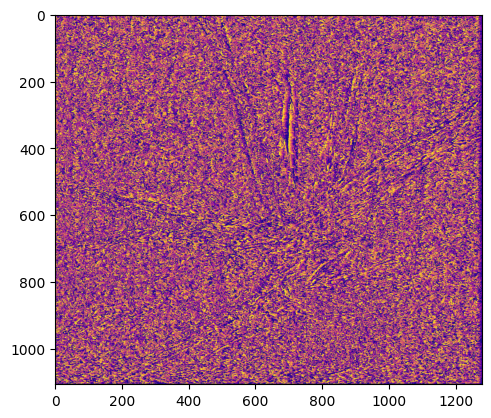

In [ ]:
plt.imshow(ct_map, cmap='plasma')

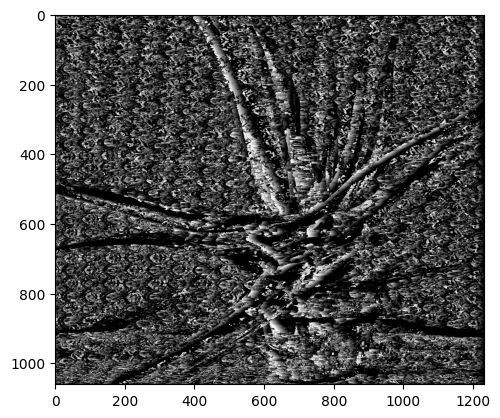

In [20]:
import cv2
import numpy as np
from tqdm.auto import tqdm
from numba import njit, prange

class CensusTransform:
    def __init__(self, ksize=5, dmax=32):
        self.ksize = ksize
        self.half_ksize = ksize // 2
        self.dmax = dmax

    def apply(self, img_left, img_right):
        census_map_left = compute_census(img_left, self.ksize)
        census_map_right = compute_census(img_right, self.ksize)
        disp_map = compute_disparity(census_map_left, census_map_right, self.dmax)
        return disp_map

@njit(parallel=True)
def compute_census(img, ksize):
    h, w = img.shape
    half = ksize // 2
    out_h = h - ksize + 1
    out_w = w - ksize + 1
    census = np.zeros((out_h, out_w), dtype=np.uint32)
    for y in prange(half, h - half):
        for x in range(half, w - half):
            center = img[y, x]
            pattern = 0
            bit = 0
            for dy in range(-half, half + 1):
                for dx in range(-half, half + 1):
                    if dy == 0 and dx == 0:
                        continue
                    pattern |= (img[y + dy, x + dx] >= center) << bit
                    bit += 1
            census[y - half, x - half] = pattern
    return census

@njit(parallel=True)
def compute_disparity(census_left, census_right, dmax):
    h, w = census_left.shape
    disp_map = np.zeros((h, w), dtype=np.uint8)
    for y in prange(h):
        for x in range(w):
            min_diff = 9999
            best_d = 0
            for d in range(dmax):
                xr = x + d
                if xr >= w:
                    break
                xor_val = census_left[y, x] ^ census_right[y, xr]
                # Liczenie liczby bitów ustawionych na 1
                diff = 0
                while xor_val:
                    diff += xor_val & 1
                    xor_val >>= 1
                if diff < min_diff:
                    min_diff = diff
                    best_d = d
            disp_map[y, x] = best_d
    return disp_map

img_left = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeL.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeR.jpg', cv2.IMREAD_GRAYSCALE)


census = CensusTransform(ksize=50, dmax=32)
disp_map = census.apply(img_left, img_right)

plt.imshow(disp_map, cmap='gray')

100%|██████████| 1104/1104 [00:17<00:00, 61.44it/s]


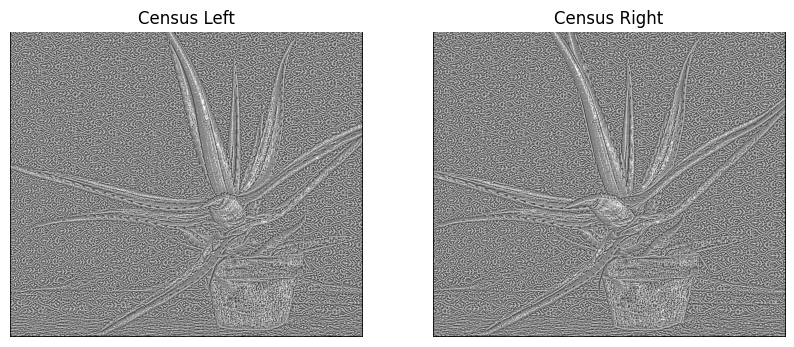

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def census_transform(img, window_size=9):
    h, w = img.shape
    offset = window_size // 2
    census = np.zeros((h, w), dtype=np.uint64)

    for y in tqdm(range(offset, h - offset)):
        for x in range(offset, w - offset):
            center = img[y, x]
            bitstring = 0
            bit = 0
            for dy in range(-offset, offset + 1):
                for dx in range(-offset, offset + 1):
                    if dy == 0 and dx == 0:
                        continue
                    bitstring <<= 1
                    if img[y + dy, x + dx] >= center:
                        bitstring |= 1
                    bit += 1
            census[y, x] = bitstring
    return census

# Wczytanie obrazów
img_left = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeL.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('/home/plorenc/Desktop/AiR_ISS/AVS/aloes/aloeR.jpg', cv2.IMREAD_GRAYSCALE)

# Sprawdzenie poprawności wczytania
assert img_left is not None and img_right is not None, "Nie można wczytać jednego z obrazów."

# Przetwarzanie obrazów
census_left = census_transform(img_left, window_size=7)
census_right = census_transform(img_right, window_size=7)

# Można np. wyświetlić wartości sumy bitów jako podgląd różnic
def visualize_census(census):
    return np.uint8(np.vectorize(lambda x: bin(x).count("1"))(census))

vis_left = visualize_census(census_left)
vis_right = visualize_census(census_right)